## Scanpy `pbmc4k`

In [ ]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

In [ ]:
results_out_root = '/home/jupyter/data/10x/out/'
marker_genes_txt = '/home/jupyter/data/10x/pbmc_marker_genes.txt'

input_root = '/home/jupyter/data/10x/out/pbmc4k__raw__mtx_output/'
output_prefix = 'pbmc4k_raw'

# input_root = '/home/jupyter/data/10x/out/pbmc4k__all_genes__11__final_3_weakreg__mtx_output/'
# output_prefix = 'pbmc4k_dtm'

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = os.path.join(results_out_root, f'{output_prefix}.h5ad')

In [ ]:
sc.settings.set_figure_params(dpi=80)

In [ ]:
adata = sc.read_10x_mtx(
    input_root,
    var_names='gene_symbols',
    cache=True) 

In [ ]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

## Load marker genes

In [ ]:
from collections import defaultdict
marker_genes_dict = defaultdict(list)

with open(marker_genes_txt, 'r') as f:
    while True:
        cluster_name = f.readline().strip()
        gene_name = f.readline().strip()
        sense = f.readline().strip()
        if sense == '+':
            sense = 1
        else:
            sense = -1
        if cluster_name == "":
            break
        marker_genes_dict[cluster_name].append((gene_name, sense))
        
all_marker_genes = []
for v in marker_genes_dict.values():
    all_marker_genes += [x[0] for x in v]
all_marker_genes = np.unique(all_marker_genes).tolist()

## Preprocessing

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, save="_" + output_prefix + '.pdf')

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [ ]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
adata

In [ ]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [ ]:
sc.pp.log1p(adata)

In [ ]:
adata.raw = adata

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [ ]:
# all_marker_genes_set = set(all_marker_genes)
# n = 0
# hvg_bool_list = []
# for gene_name in adata.var.index:
#     if gene_name in all_marker_genes_set:
#         hvg_bool_list.append(True)
#     else:
#         hvg_bool_list.append(False)
# adata.var['highly_variable'] = hvg_bool_list

In [ ]:
adata = adata[:, adata.var['highly_variable']]

In [ ]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [ ]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

In [ ]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=100)

In [ ]:
sc.pl.pca(adata, color='CST3')

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
adata

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata)
# sc.pl.umap(adata,
#            color=['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
#                   'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
#                   'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP'],
#            save="_" + output_prefix + '.pdf')

In [ ]:
adata.write(results_file)

## Clustering

In [ ]:
adata = sc.read(results_file)

In [ ]:
# raw -> 0.7
# dtm -> 1.0
louvain_resolution = 1.5
sc.tl.louvain(adata, resolution=louvain_resolution)

if 'cell_type' in adata.obs.columns:
    adata.obs = adata.obs.drop(columns=['cell_type'])
adata.obs.insert(len(adata.obs.columns), 'cell_type', adata.obs['louvain'].values.tolist())

In [ ]:
# considered_cell_types = ['Cytotoxic T cell', 'Megakaryocyte', 'CD16+ monocyte', 'CD4+ T cell', 'CD14+ monocyte', 'B cell']

considered_cell_types = list(marker_genes_dict.keys())

In [ ]:
considered_cell_types

In [ ]:
max_cluster_index = max([int(x) for x in adata.obs['louvain'].values.tolist()])
score_matrix = np.zeros((max_cluster_index + 1, len(considered_cell_types)))
for cluster_index in range(max_cluster_index + 1):
    print(cluster_index)
    cluster_adata = adata[adata.obs['louvain'] == str(cluster_index), :]
    for cell_type_index, cell_type in enumerate(considered_cell_types):
        cell_type_ann = marker_genes_dict[cell_type]
        score = 0.
        for gene_name, sense in cell_type_ann:
            try:
                score += np.sum(cluster_adata[:, gene_name].X * sense).item()
            except:
                pass
        score_matrix[cluster_index, cell_type_index] = score

In [ ]:
plt.imshow(score_matrix)

In [ ]:
cell_type_assignment = np.argmax(score_matrix, -1)
for i, v in enumerate(adata.obs['louvain'].values):
    adata.obs['cell_type'].values[i] = considered_cell_types[cell_type_assignment[int(v)]]

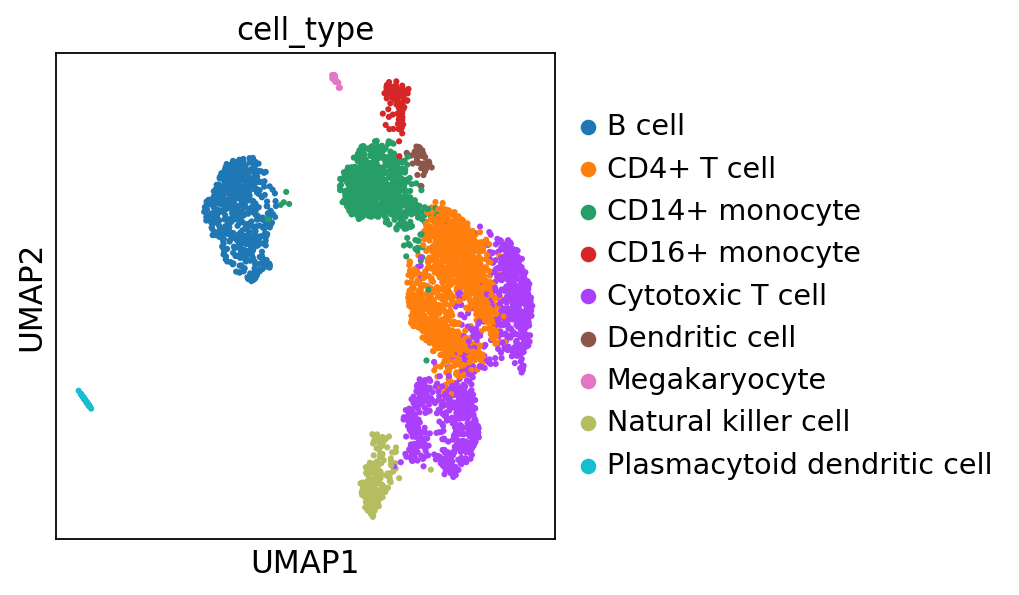

<Figure size 320x320 with 0 Axes>

In [330]:
import matplotlib.pylab as plt
sc.pl.umap(adata, color=['cell_type'])
# sc.pl.umap(adata[adata.obs['cell_type'] == 'Megakaryocyte', :], size=5)
plt.tight_layout()

In [ ]:
adata.write(results_file)

## Marker genes

In [ ]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

In [ ]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata.write(results_file)

In [ ]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [ ]:
adata = sc.read(results_file)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
# sc.tl.rank_genes_groups(adata, 'cell_type', groups=['0'], reference='1', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
adata = sc.read(results_file)

In [ ]:
# sc.tl.rank_genes_groups(adata, 'louvain', groups=['12'], reference='13', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, groups=['12'], n_genes=20)

In [ ]:
# sc.pl.rank_genes_groups_violin(adata, groups='12', n_genes=8)

In [ ]:
# adata = sc.read(results_file)
# sc.pl.rank_genes_groups_violin(adata, groups='13', n_genes=8)

In [ ]:
# sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

In [ ]:
# new_cluster_names = [
#     'CD4 T', 'CD14+ Monocytes',
#     'B', 'CD8 T',
#     'NK', 'FCGR3A+ Monocytes',
#     'Dendritic', 'Megakaryocytes']
# adata.rename_categories('louvain', new_cluster_names)

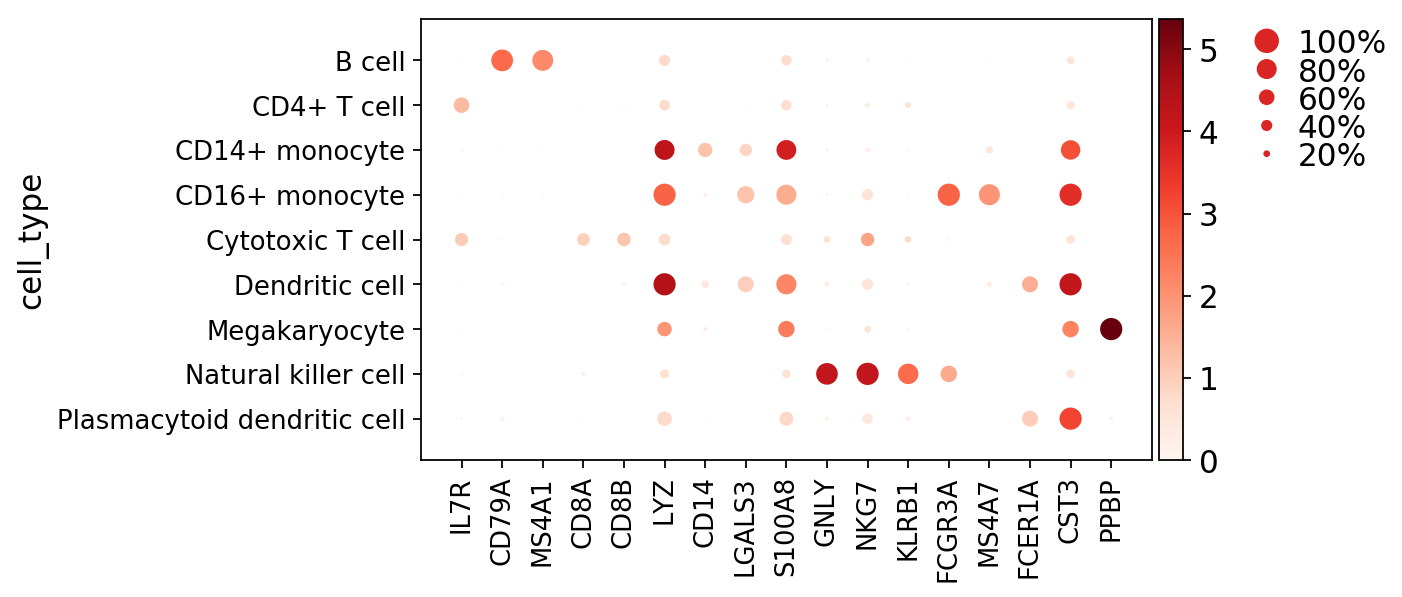

In [329]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='cell_type', save="_" + output_prefix + '.pdf')

In [ ]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='cell_type', rotation=90, save="_" + output_prefix + '.pdf')

In [ ]:
adata

In [ ]:
adata.write(results_file)